# Topic model
SanjayKAroraPhD@gmail.com <br>
December 2018

## Description
This notebook trains topic models on firm pages, segmenting those pages by firm groups as appropriate, and prepares topic modeling outputs at the paragraph level for subsequent Markov modeling

## TODO:
Consider changing LdaMulticore to Mallet LDA implementation

In [1]:
%matplotlib inline
import os
import os.path
import random
import re
import gensim
import string
import math
from gensim import corpora
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from collections import defaultdict
import copy as cp
from bs4 import BeautifulSoup
from functools import reduce 
import operator
import matplotlib.pyplot as plt
import pprint
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import pprint
import pyLDAvis
import pyLDAvis.gensim

In [2]:
# set this home data dir
BASE_DATA_DIR = "/Users/sarora/dev/EAGER/data/"

## Load website data from file
Look for text files prepared from MongoDB (the Scrapy scraper)

In [3]:
#import demo text files
in_path = BASE_DATA_DIR + 'orgs/depth0_boilerpipe/' # where in files are stored
out_file = in_path + 'out_topics.csv' # where output files are stored
files = os.listdir(in_path)
files = [item for item in files if item.endswith('.txt')]

In [4]:
#generate pooled text and list of processed documents for topic model
combined_text = []
documents_dict = {}
for i in range(len(files)):
    with open(in_path + files[i], 'r') as my_file:
        text = my_file.readlines() # this is each separate paragraph including headers etc
        for k in ["\n", "\t", " "]: # remove the end of sentence tags
            text = [item.strip(k) for item in text]
        text = list(filter(lambda x : not x in [' ', '', '\t'],text)) #remove the paragraphs that are just blank space
        documents_dict[files[i]] = text #make a list of lists

## Data Prep

### Prepare text for topic modelling

In [5]:
# run once if needed and download the popular corpora (e.g., stopwords) 
nltk.download(['stopwords', 'punkt'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sarora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sarora/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
#tokenize text for topic modelling
def encode_item(text):
    '''
    Remove characters with encoding problems 
    '''
    clean = ""
    for item in text.split(" "):
        try:
            clean += str(item).encode('ascii','ignore') + " "
        except: 
            pass
    return clean.rstrip()

stopwords = nltk.corpus.stopwords.words('english') + list(set(string.punctuation))
stemmer = SnowballStemmer("english")

def stem_tokenizer(text):
    '''
    Tokenize and stem an input sentence"
    '''
    words_stemmed = list(filter(lambda x : not x in stopwords, [stemmer.stem(word) for word in nltk.word_tokenize(text)]))
    return words_stemmed

def clean_text (text):
    p = re.compile(r"''|``|null|ul|li|ol|^\.|^:|^/|\\|'s", flags=re.IGNORECASE)
    clnd_text = list(filter(lambda x : not p.match(x), text))
    return clnd_text

def return_for_model(text):
    '''
    Deal with endcoding and return stemmed/tokenized text
    '''
    all_content = [encode_item(item) for item in text] 
    all_content_stem_token = list(map(stem_tokenizer, all_content))
    all_content_clnd = list(map(clean_text, all_content_stem_token))
        
    return all_content_clnd

In [7]:
def process_doc_list(dict_of_docs):
    '''
    input: lists of documents (which are individually lists of paragraphs)
    output: returns a test/train split of paragraphs and stemmed documents
    '''
    combined_text = []
    documents = []
    dict_of_processed_docs = {}
    print ("Working on " + str(len(dict_of_docs.keys())) + " documents")
    c = 1
    for key in dict_of_docs:
        document = dict_of_docs[key]
        # print ("Working on doc " + key)
        # loop over text and add title elements to the paragraph they describe
        joined = []
        buffer = ""
        for i in range(len(document)):
            if len(document[i]) < 12: # maybe a menu or simple pagragraph heading? 
                continue
            buffer = buffer + document[i] + ' ' 
            # TODO: must implement a better way to define pagraphs, e.g., on sentences or paragraph tags
            if len(buffer) > 100:
                joined.append(buffer.rstrip())
                buffer = ""
        joined.append(buffer.rstrip())
        combined_text += joined # make a big list
        documents.append(joined) # make a list of lists
        dict_of_processed_docs[key] = return_for_model(joined)
    
    combined = return_for_model(combined_text)
    random.shuffle(combined) #randomly shuffle in order to make test train split
    train_index = int(np.round(len(combined)*.8)) #about 80% in the training set
    train = combined[:train_index]
    test = combined[train_index:]
    return train, test, dict_of_processed_docs

### Process Documents for Topic Modelling

In [10]:
# use the preceeding fuction to process the text data
all_train, all_test, all_docs_dict = process_doc_list(documents_dict)
# pp = pprint.PrettyPrinter()
# pp.pprint(all_docs_dict.keys())

Working on 1147 documents


In [11]:
print (len(all_train))
print (len(all_test))
print (len(all_docs_dict.keys()))

19498
4874
1147


In [12]:
print(all_docs_dict['Ablexis.txt'])

[[u'intellectu', u'properti', u'alivamab', u'mous', u'immunoglobulin', u'locus', u'engin', u'intellectu', u'properti', u'alivamab', u'mous', u'immunoglobulin', u'locus', u'engin'], [u'intellectu', u'properti', u'alivamab', u'mous', u'immunoglobulin', u'locus', u'engin', u'effici', u'discoveri', u'develop', u'antibodi', u'antibody-deriv', u'drug', u'candid'], [u'option', u'design', u'meet', u'need', u'partner', u'ablexi', u'announc', u'progress', u'intellectu', u'properti', u'alivamab', u'mous', u'immunoglobulin', u'locus', u'engin'], [u'10581', u'rosell', u'street', u'suit', u'115', u'san', u'diego', 'ca', u'92121']]


In [13]:
SEGMENT_DIR = BASE_DATA_DIR + "orgs/segments/"
def pick_firms (firm_file, all_docs_dict):
    with open(SEGMENT_DIR + firm_file) as f:
        firms = f.readlines()
    clnd_file_names = list(map (lambda x: re.sub('\\.|\\/', '_', x).rstrip('\r\n') + '.txt', firms))
    segment_dict = {}
    for name in clnd_file_names:
        if name in all_docs_dict:
            segment_dict[name] = all_docs_dict[name]
        else: 
            pass 
            # print "Cannot find " + name
    return segment_dict

In [20]:
# create different training sets by industry
green_firms_file = "green_firms.csv"
synbio_firms_file = "synbio_firms.csv"
nano_firms_file = "nano_firms.csv"

green_docs_dict= pick_firms(green_firms_file, documents_dict)
green_train, green_test, green_docs = process_doc_list(green_docs_dict)

synbio_docs_dict= pick_firms(synbio_firms_file, documents_dict)
synbio_train, synbio_test, synbio_docs = process_doc_list(synbio_docs_dict)

nano_docs_dict= pick_firms(nano_firms_file, documents_dict)
nano_train, nano_test, nano_docs = process_doc_list(nano_docs_dict)

Working on 406 documents
Working on doc Big Belly Solar.txt
Working on doc BlackBerry Limited.txt
Working on doc SunCulture Solar Inc_.txt
Working on doc Rio Grande Valley Sugar Growers.txt
Working on doc ZENA TECHNOLOGIES.txt
Working on doc Solaire Generation LLC.txt
Working on doc E_ Tech Incorporation.txt
Working on doc JFE STEEL CORPORATION.txt
Working on doc Sunlight Photonics Inc_.txt
Working on doc ZON.txt
Working on doc Total Marketing Services.txt
Working on doc Industrial Technology Research Institute.txt
Working on doc Helios Focus LLC.txt
Working on doc Simbol Inc_.txt
Working on doc UChicago Argonne.txt
Working on doc Hollywood Trucks.txt
Working on doc NanoGram Corporation.txt
Working on doc Advanced Aqua Group.txt
Working on doc Sungevity Inc_.txt
Working on doc Kimberly-Clark Worldwide.txt
Working on doc Newdoll Enterprises LLC.txt
Working on doc Fianium Ltd_.txt
Working on doc Rockwell Collins.txt
Working on doc Esolar.txt
Working on doc FUJIFILM Corporation.txt
Workin

Working on doc First Solar.txt
Working on doc AMPT.txt
Working on doc Amtech Systems.txt
Working on doc HOWARD INDUSTRIES.txt
Working on doc SunLink Corporation.txt
Working on doc Biogenic Reagents Ventures.txt
Working on doc Atonometrics.txt
Working on doc Arkema Inc_.txt
Working on doc Marathon Equipment Company.txt
Working on doc Hyundai Motor Company.txt
Working on doc Schneider Electric Solar Inverters USA.txt
Working on doc Lof Solar Corporation.txt
Working on doc CoolEarth Solar.txt
Working on doc Toyota Motor Engineering & Manufacturing North America.txt
Working on doc Dresser-Rand Company.txt
Working on doc Sumco Corporation.txt
Working on doc Global Solar Water Power Systems.txt
Working on doc NEC Corporation.txt
Working on doc United Technologies Corporation.txt
Working on doc VINYLAST.txt
Working on doc GENERAL MOTORS LLC.txt
Working on doc SolarWorld Americas Inc_.txt
Working on doc Alcotek.txt
Working on doc POET Research.txt
Working on doc Heliae Development.txt
Working 

Working on doc Pharmion Corporation.txt
Working on doc Empire Technology Development LLC.txt
Working on doc Revivicor.txt
Working on doc Roche Diagnostics GmbH.txt
Working on doc Atrium Medical Corporation.txt
Working on doc Auterra.txt
Working on doc Quest Diagnostics Investments Incorporated.txt
Working on doc Dow AgroSciences LLC.txt
Working on doc Reynolds Technologies.txt
Working on doc Industrial Technology Research Institute.txt
Working on doc Nordson Corporation.txt
Working on doc Qiagen GmbH.txt
Working on doc Denso Corporation.txt
Working on doc Epizyme.txt
Working on doc Syngenta Participations AG.txt
Working on doc S_ C_ Johnson & Son.txt
Working on doc MIETAMARK GENETICS.txt
Working on doc Xerox Corporation.txt
Working on doc Vascular BioSciences.txt
Working on doc Phillips 66 Company.txt
Working on doc UT-Battelle.txt
Working on doc Autonomic Materials.txt
Working on doc Agrivida.txt
Working on doc Sony Interactive Entertainment America LLC.txt
Working on doc Cleanvantage

Working on doc Ion Power Group.txt
Working on doc Diamond Innovations.txt
Working on doc Magnachip Semiconductor.txt
Working on doc Cross Match Technologies.txt
Working on doc ACACIA RESEARCH GROUP LLC.txt
Working on doc JFE STEEL CORPORATION.txt
Working on doc Gtech Corporation.txt
Working on doc SAINT-GOBAIN ABRASIFS.txt
Working on doc Sanofi.txt
Working on doc Freescale Semiconductor.txt
Working on doc II-VI Incorporated.txt
Working on doc OLYMPUS CORPORATION.txt
Working on doc Polysar Corporation.txt
Working on doc Nova Technologies.txt
Working on doc NanoOncology.txt
Working on doc Mediatek Inc_.txt
Working on doc CUMMINS FILTRATION IP.txt
Working on doc Omron Corporation.txt
Working on doc Industrial Technology Research Institute.txt
Working on doc Alnylam Pharmaceuticals.txt
Working on doc UChicago Argonne.txt
Working on doc Biosense Webster (Israel) Ltd_.txt
Working on doc DHPC TECHNOLOGIES.txt
Working on doc NanoGram Corporation.txt
Working on doc IntriEnergy Inc_.txt
Working 

Working on doc Cisco Technology.txt
Working on doc S&S X-Ray Products.txt
Working on doc International Technology Center.txt
Working on doc Siemens Medical Solutions USA.txt
Working on doc Archer Daniels Midland Company.txt
Working on doc Honeywell International Inc_.txt
Working on doc Pentron Clinical Technologies.txt
Working on doc Industrial Science & Technology Network.txt
Working on doc Kinetech Power Company LLC.txt
Working on doc Toyota Motor Engineering & Manufacturing North America.txt
Working on doc Smith & Nephew.txt
Working on doc Canon Nanotechnologies.txt
Working on doc Renesas Electronics Corporation.txt
Working on doc Pentair Thermal Management LLC.txt
Working on doc DECA Technologies Inc_.txt
Working on doc Brewer Science Inc_.txt
Working on doc ATTOSTAT.txt
Working on doc Dermazone Solutions.txt
Working on doc ExxonMobil Upstream Research Company.txt
Working on doc Perkinelmer Holdings.txt
Working on doc Lintec Corporation.txt
Working on doc ADASA INC_.txt
Working on 

Working on doc NOK Corporation.txt
Working on doc Fuji Electric Co_.txt
Working on doc Englewood Lab.txt
Working on doc Siluria Technologies.txt
Working on doc Sequenom.txt
Working on doc Heidelberger Druckmaschinen AG.txt
Working on doc Takeda Pharmaceutical Company Limited.txt
Working on doc Opel Solar.txt
Working on doc Invensas Corporation.txt
Working on doc Unity Semiconductor Corporation.txt
Working on doc Toshiba America Electronic Components.txt
Working on doc CAMBRIDGE ENTERPRISE LIMITED.txt
Working on doc Fuji Xerox Co_.txt
Working on doc Johnson & Johnson Vision Care.txt
Working on doc Solar Junction Corporation.txt
Working on doc Korea Kumho Petrochemical Co_.txt
Working on doc Silicon Genesis Corporation.txt
Working on doc Hewlett Packard Enterprise Development LP.txt
Working on doc Raytheon Company.txt
Working on doc Biological Dynamics.txt
Working on doc Fina Technology.txt
Working on doc Sensor Electronic Technology.txt
Working on doc AGFA-GEVAERT N_V_.txt
Working on do

In [21]:
small_firms_file = "small_firms.csv"
medium_firms_file = "medium_firms.csv"
large_firms_file = "large_firms.csv"

small_docs_dict= pick_firms(small_firms_file, documents_dict)
small_train, small_test, small_docs = process_doc_list(small_docs_dict)

medium_docs_dict= pick_firms(medium_firms_file, documents_dict)
medium_train, medium_test, medium_docs = process_doc_list(medium_docs_dict)

large_docs_dict= pick_firms(large_firms_file, documents_dict)
large_train, large_test, large_docs = process_doc_list(large_docs_dict)

Working on 577 documents
Working on doc Big Belly Solar.txt
Working on doc FRONT EDGE TECHNOLOGY INC_.txt
Working on doc SunCulture Solar Inc_.txt
Working on doc Kamtec.txt
Working on doc Mattson Technology.txt
Working on doc ZENA TECHNOLOGIES.txt
Working on doc Ion Power Group.txt
Working on doc Diamond Innovations.txt
Working on doc Great American Duck Races.txt
Working on doc ACACIA RESEARCH GROUP LLC.txt
Working on doc JFE STEEL CORPORATION.txt
Working on doc Sunlight Photonics Inc_.txt
Working on doc ZON.txt
Working on doc OLYMPUS CORPORATION.txt
Working on doc Polysar Corporation.txt
Working on doc Nova Technologies.txt
Working on doc NanoOncology.txt
Working on doc Total Marketing Services.txt
Working on doc Industrial Technology Research Institute.txt
Working on doc SB ENERGY.txt
Working on doc Simbol Inc_.txt
Working on doc Vascular BioSciences.txt
Working on doc Hollywood Trucks.txt
Working on doc Autonomic Materials.txt
Working on doc ASCENT SOLAR TECHNOLOGIES.txt
Working on

Working on doc Ignis Innovation.txt
Working on doc Nanoholdings.txt
Working on doc Magnolia Optical Technologies.txt
Working on doc Tessera.txt
Working on doc Locus Energy.txt
Working on doc GLIKNIK INC_.txt
Working on doc Sanyo Electric Co_.txt
Working on doc Xyleco.txt
Working on doc Floadia Corporation.txt
Working on doc TOMOWAVE LABORATORIES.txt
Working on doc Canon Kabushiki Kaisha.txt
Working on doc PLYCEM USA.txt
Working on doc Ceramatec.txt
Working on doc ECOSYNTHETIX LTD_.txt
Working on doc Nanospectra Biosciences.txt
Working on doc Nexcom Technology.txt
Working on doc Ford Global Technologies.txt
Working on doc Akron Polymer Systems.txt
Working on doc SixPoint Materials.txt
Working on doc WOVN.txt
Working on doc Cellular Research.txt
Working on doc IDEALAB.txt
Working on doc Astech.txt
Working on doc Aurora Alage.txt
Working on doc Narsys.txt
Working on doc ALGETERNAL TECHNOLOGIES.txt
Working on doc Photon Dynamics.txt
Working on doc Basell Polyolefine GmbH.txt
Working on doc

Working on doc Alpha and Omega Semiconductor Incorporated.txt
Working on doc GlassPoint Solar.txt
Working on doc Coleman Cable.txt
Working on doc Cool Planet Energy Systems.txt
Working on doc Everspin Technologies.txt
Working on doc DiscoveRx Corporation.txt
Working on doc HRL Laboratories.txt
Working on doc Korea Kumho Petrochemical Co_.txt
Working on doc Texas Research International.txt
Working on doc ASM America.txt
Working on doc Richtek Technology Corporation.txt
Working on doc Zephyr Energy Systems LLC.txt
Working on doc Paratek Pharmaceuticals.txt
Working on doc Kashiv Pharma.txt
Working on doc PLEX LLC.txt
Working on doc Kinestral Technologies.txt
Working on doc BASF Coatings GmbH.txt
Working on doc Aerogen.txt
Working on doc Bridgelux.txt
Working on doc KYOCERA DOCUMENT SOLUTIONS INC_.txt
Working on doc Singulex.txt
Working on doc Intellectual Keystone Technology LLC.txt
Working on doc Medicis Pharmaceutical Corporation.txt
Working on doc Zygo Corporation.txt
Working on doc Co

Working on doc PPG Industries Ohio.txt
Working on doc The Procter & Gamble Company.txt
Working on doc Innolux Corporation.txt
Working on doc Electrix.txt
Working on doc Alcon Research.txt
Working on doc Hoya Corporation.txt
Working on doc Biocon Limited.txt
Working on doc Gilead Sciences.txt
Working on doc H R D CORPORATION.txt
Working on doc Siemens Aktiengesellschaft .txt
Working on doc Fluidigm Corporation.txt
Working on doc Globus Medical.txt
Working on doc Johnson Controls Technology Company.txt
Working on doc Bausch & Lomb Incorporated.txt
Working on doc Shell Oil Company.txt
Working on doc ServiceNow.txt
Working on doc Roche Molecular Systems.txt
Working on doc Dolby Laboratories Licensing Corporation.txt
Working on doc Cree.txt
Working on doc O_B_I_ Inc_.txt
Working on doc Dialight Corporation.txt
Working on doc Illinois Tool Works.txt
Working on doc Apple Inc_.txt
Working on doc Red Hat.txt
Working on doc GE-Hitachi Nuclear Energy Americas LLC.txt
Working on doc DePuy Synthes 

In [15]:
# train on all docs or a subset
new_train = all_train + all_test
# new_train = synbio_train + synbio_test
# new_train = nano_train + nano_test 
# new_train = green_train + green_test

# new_train = small_train + small_test
# new_train = medium_train + medium_test 
# new_train = large_train + large_test

full_dict = corpora.Dictionary(new_train)
DT_matrix = [full_dict.doc2bow(doc) for doc in new_train]

## Run Topic Modelling

In [13]:
def topic_model(train, test, topics):
    '''
    input: preprocessed test and training data, optionally the number of topics
    output: a fitted LDA topic model and the bow representation of test data for model evaluation
    '''
    random.seed(1)
    #create topic model on full text
    #will need to run on server when we have more data
    full_dict = corpora.Dictionary(train)
    DT_matrix = [full_dict.doc2bow(doc) for doc in train]
    test_token = [full_dict.doc2bow(doc) for doc in test]
    lda = LdaMulticore(DT_matrix, id2word=full_dict, num_topics=topics) 
    return lda, test_token

In [14]:
k = [2, 5, 10, 15, 20, 25, 30, 40 , 50, 75, 100] # possible number of topics
def calculate_perplexities(train,test, k):
    '''
    inputs: preprocessed test and training data, a list of possible number of topics
    outputs: log perplexity and perplexity, scored on the test set
    '''
    log_perplexities = []
    perplexity = []
    for i in k:
        model, test_doc2bow = topic_model(train, test, i)
        log_p = model.log_perplexity(test_doc2bow)
        log_perplexities.append(log_p)
        perp = model.bound(test_doc2bow)
        perplexity.append(perp)
    return log_perplexities, perplexity

In [15]:
all_log_perplexities, all_perplexities = calculate_perplexities(all_train, all_test, k)

/Users/sarora/anaconda2/lib/python2.7/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [27]:
green_log_perplexities, green_perplexities = calculate_perplexities(green_train, green_test, k)
synbio_log_perplexities, synbio_perplexities = calculate_perplexities(synbio_train, synbio_test, k)
nano_log_perplexities,nano_perplexities= calculate_perplexities(nano_train, nano_test, k)

In [28]:
small_log_perplexities, small_perplexities = calculate_perplexities(small_train, small_test, k)
medium_log_perplexities, medium_perplexities = calculate_perplexities(medium_train, medium_test, k)
large_log_perplexities,large_perplexities= calculate_perplexities(large_train, large_test, k)

### Perplexity Plots for each website type

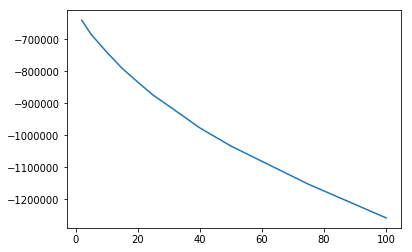

In [29]:
import matplotlib.pyplot as plt
plt.plot(k, all_perplexities)

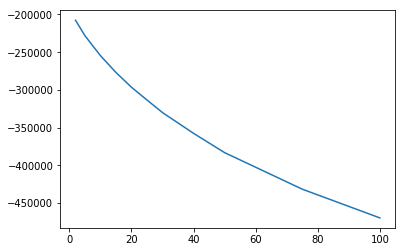

In [30]:
plt.plot(k, green_perplexities)

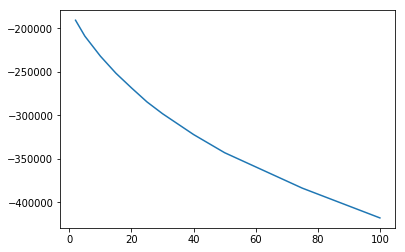

In [31]:
plt.plot(k, synbio_perplexities)

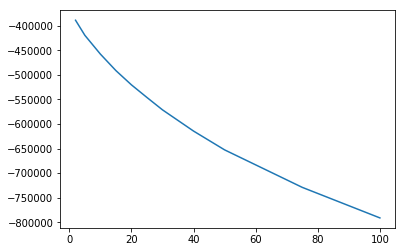

In [32]:
plt.plot(k, nano_perplexities)

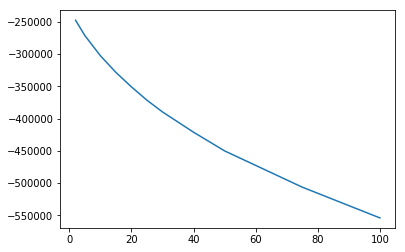

In [33]:
plt.plot(k, small_perplexities)

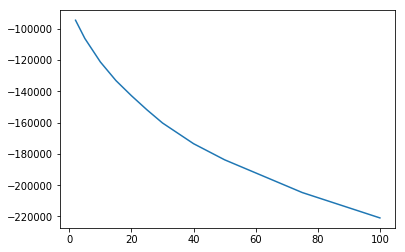

In [34]:
plt.plot(k, medium_perplexities)

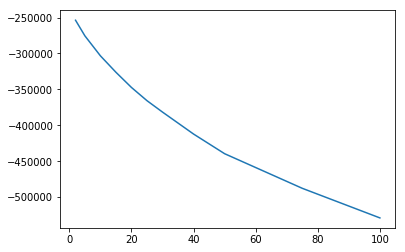

In [35]:
plt.plot(k, large_perplexities)

### Coherence scores
Code from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ (#17).

In [36]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [37]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=full_dict, corpus=DT_matrix, texts=new_train, start=2, limit=20,step=2)

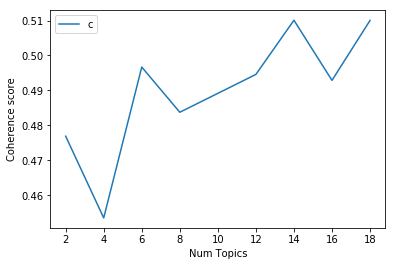

In [38]:
# Show graph
limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Predict topics by paragraph

In [16]:
# define data structs and train model
k = 6
topic_by_firm_vector = {} # at the firm level
lda = LdaMulticore(DT_matrix, id2word=full_dict, num_topics=k)

#### Visualize topics

In [18]:
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, DT_matrix, full_dict)
pyLDAvis.display(LDAvis_prepared)

In [19]:
x=lda.show_topics(num_topics=k, num_words=10,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
#Below Code Prints Topics and Words
labels = []
for topic,words in topics_words:
    print(str(topic)+ "::"+ str(words))
    labels.append('|'.join(words[0:3]))

0::[u'product', u'use', u'develop', u'power', u'inform', u'servic', u'system', u'manufactur', u'compani', u'custom']
1::[u'new', u'product', u'2018', u'servic', u'technolog', u'power', u'compani', u'energi', u'use', u'solut']
2::[u'product', u'system', u'new', u'technolog', u'2018', u'solut', u'use', u'formul', u'help', u'process']
3::[u'product', u'support', u'manag', u'servic', u'develop', u'solut', u'applic', u'technolog', u'new', u'secur']
4::[u'technolog', u'product', u'solut', u'2018', u'innov', u'custom', u'energi', u'servic', u'industri', u'research']
5::[u'servic', u'technolog', u'product', u'system', u'use', u'solut', u'inform', u'2018', u'global', u'polici']


In [20]:
# print topic labels for import into R (note these need to be copied into R every time you train a new topic model)
print ("Copy this into R:")
print ('c("' + '", "'.join(labels) + '")')

Copy this into R:
c("product|use|develop", "new|product|2018", "product|system|new", "product|support|manag", "technolog|product|solut", "servic|technolog|product")


#### Create output data structure and write to file

In [21]:
# create output data structure
for firm_key in all_docs_dict:
    firm_paras = all_docs_dict[firm_key]
    main_topic = [] # at the firm level, where each para is an entry
    main_topic_probs = [] # same, but for probabilities
    para_order = []
    para_len = [] 
    order_num = 1
    for para in firm_paras:
        para_len.append(len(para))
        topic_by_prob = sorted([(i[1],i[0]) for i in lda.get_document_topics(full_dict.doc2bow(para))], reverse = True)
        main_topic.append(topic_by_prob[0][1])
        main_topic_probs.append(topic_by_prob[0][0])
        para_order.append(order_num)
        order_num = order_num + 1
    firm_df = pd.DataFrame(
        {'firm': firm_key.split('.')[0], 
         'para_order': para_order,
         'num_words': para_len,
         'main_topic': main_topic,
         'prob': main_topic_probs
        })
    topic_by_firm_vector[firm_key] = firm_df # set at the firm level 

In [22]:
# Test output for a given firm 
print ('Found output for ' + str(len(topic_by_firm_vector.keys())) + ' firms.  Here is an example:')
pp = pprint.PrettyPrinter()
pp.pprint (documents_dict['Ablexis.txt'])
# pp.pprint (all_docs_dict['Ablexis.txt'])
print(topic_by_firm_vector['Ablexis.txt'])

Found output for 1147 firms.  Here is an example:
['in Its Intellectual Property on AlivaMab Mouse and Immunoglobulin Locus Engineering',
 'in Its Intellectual Property on AlivaMab Mouse and Immunoglobulin Locus Engineering',
 'in Its Intellectual Property on AlivaMab Mouse and Immunoglobulin Locus Engineering',
 'MORE',
 'Next',
 '1',
 '2',
 '3',
 'About',
 'For efficient discovery and development of antibody and antibody-derivative drug candidates.',
 'Our license options are designed to meet the needs of our partners.',
 'Ablexis Announces Progress in Its Intellectual Property on AlivaMab Mouse and Immunoglobulin Locus Engineering',
 '10581 Roselle Street, Suite 115',
 'San Diego, CA 92121']
      firm  main_topic  num_words  para_order      prob
0  Ablexis           0         14           1  0.943983
1  Ablexis           0         14           2  0.944046
2  Ablexis           0         15           3  0.947434
3  Ablexis           0          9           4  0.916074


In [47]:
# Write to a single output topic file
headers = list(topic_by_firm_vector[list(topic_by_firm_vector.keys())[0]])
if os.path.isfile(out_file) :
    os.remove(out_file)
with open(out_file, 'a') as f:
    f.write(','.join(headers) + '\n')
    for firm_key in topic_by_firm_vector:
        df = topic_by_firm_vector[firm_key]
        df.to_csv(f, header=False, index=False)
        
# now go to R